## __CNN + CBAM for Classification__

In [18]:
## importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel
from tensorflow.keras.layers import RandomRotation, RandomContrast, RandomTranslation, RandomBrightness, RandomFlip    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Reshape, Multiply, Add, Activation, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
## setting up the images directory

images_dir = '../data/classification'
img_dimensions = (112, 112, 3)

print(os.listdir(images_dir))

['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [3]:
## loading dataset with 9 classses stored in 9 independent lists with 9 lists of labels
## the dataset is stored in a folder called "dataset" in the current working directory

def load_dataset(i):
    dataset = []
    labels = []
    
    path = images_dir + '/' + str(i)
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, (112, 112))
        dataset.append(img)
        labels.append(i)
    return np.array(dataset), np.array(labels)

In [4]:
class_0, labels_0 = load_dataset(0)
class_1, labels_1 = load_dataset(1)
class_2, labels_2 = load_dataset(2)
class_3, labels_3 = load_dataset(3)
class_4, labels_4 = load_dataset(4)
class_5, labels_5 = load_dataset(5)
class_6, labels_6 = load_dataset(6)
class_7, labels_7 = load_dataset(7)
class_8, labels_8 = load_dataset(8)

In [5]:
def normalize(train_images):
    return train_images / 255.0

In [6]:
X = np.concatenate((class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8))
y = np.concatenate((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8))
X.shape, y.shape

((3520, 112, 112, 3), (3520,))

In [7]:
X = normalize(X)

In [8]:
## free tge class variables to save memory

del class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8

In [9]:
## splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2816, 112, 112, 3), (704, 112, 112, 3), (2816,), (704,))

In [15]:
## base transfer learning CNN defn

IMAGE_SIZE = [112, 112]
K = 9

ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [21]:
import tensorflow as tf

## defining CBAM block
def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module"""
    channel = input_feature.shape[-1]

    # Channel attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    channel_attention = Activation('sigmoid')(avg_pool)

    # Spatial attention
    avgpool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    maxpool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    spatial = Concatenate()([avgpool, maxpool])

    spatial = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(spatial)

    # Multiply
    refined_feature = Multiply()([input_feature, channel_attention])
    refined_feature = Multiply()([refined_feature, spatial])

    return Add()([refined_feature, input_feature])


def create_modified_vgg16(input_shape=(112, 112, 3), num_classes=K):
    base_model = PretrainedModel(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False

    # Get the output of specific layers where we want to add CBAM
    x = base_model.input
    for layer in base_model.layers[1:]:
        x = layer(x, training=False)
        if layer.name in ['block2_conv2', 'block3_conv3', 'block4_conv3']:
            x = cbam_block(x)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the modified model
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [22]:
# Create the model
model = create_modified_vgg16()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 112, 112,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 112, 112,  │     36,928 │ block1_conv1[1][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 56, 56,    │          0 │ block1_conv2[1][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 56, 56,    │     73,856 │ block1_pool[1][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 56, 56,    │    147,584 │ block2_conv1[1][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ block2_conv2[1][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1, 16)  │      2,064 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1, 128) │      2,176 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 56, 56, 1) │          0 │ block2_conv2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 56, 56, 1) │          0 │ block2_conv2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 1, 128) │          0 │ dense_6[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56, 2) │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ block2_conv2[1][… │
│                     │ 128)              │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56, 1) │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 56, 56,    │          0 │ multiply[0][0],   │
│ (Multiply)          │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ multiply_1[0][0], │
│                     │ 128)              │            │ block2_conv2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 28, 28,    │          0 │ add[0][0]       

 Total params: 14,950,370 (57.03 MB)

 Trainable params: 235,682 (920.63 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
        for base_layer in layer.layers:
            base_layer.trainable = False

In [24]:
# Make sure the CBAM blocks and dense layers are trainable
for layer in model.layers:
    if 'cbam' in layer.name or isinstance(layer, Dense):
        layer.trainable = True

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
]

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, validation_data=(X_test, y_test), epochs=12, callbacks=callbacks)

Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.2664 - loss: 2.0580 - val_accuracy: 0.8097 - val_loss: 0.9818
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8273 - loss: 0.7783 - val_accuracy: 0.9418 - val_loss: 0.2712
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9438 - loss: 0.2434 - val_accuracy: 0.9759 - val_loss: 0.1316
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9750 - loss: 0.1173 - val_accuracy: 0.9830 - val_loss: 0.0816
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9849 - loss: 0.0785 - val_accuracy: 0.9872 - val_loss: 0.0634
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9916 - loss: 0.0478 - val_accuracy: 0.9929 - val_loss: 0.0397
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9935 - loss: 0.0349 - val_accuracy: 0.9972 - val_loss: 0.0258
Epoch 8/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9972 - loss: 0.0237 - val_accu

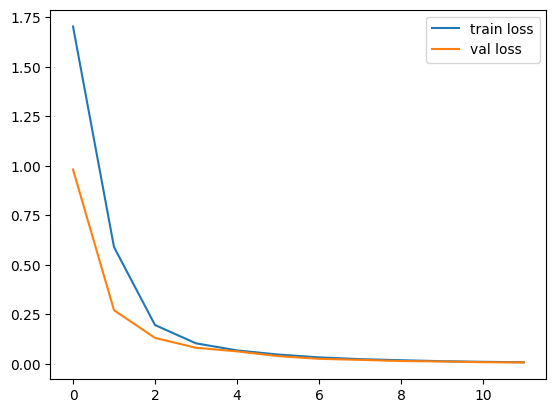

In [27]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [28]:
for layer in model.layers[-53:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history = model.fit(X, y, validation_data=(X_test, y_test), epochs=7, callbacks=callbacks)

Epoch 1/7
110/110 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9950 - loss: 0.0164 - val_accuracy: 0.9972 - val_loss: 0.0090
Epoch 2/7
110/110 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9925 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/7
110/110 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 1.8753e-04
Epoch 4/7
 12/110 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - accuracy: 1.0000 - loss: 1.8266e-04

KeyboardInterrupt: 

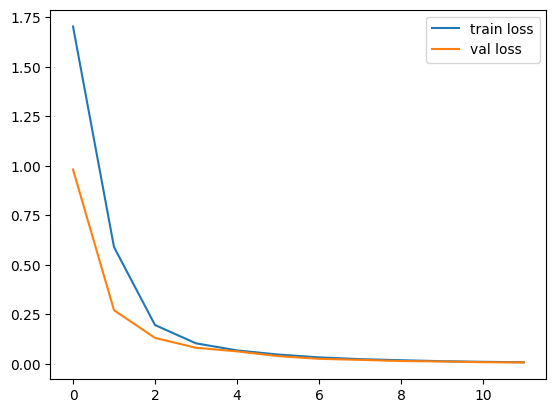

In [29]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [30]:
## model evaluation

model.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 1.0000 - loss: 2.1556e-04


[0.00013518465857487172, 1.0]